In [1]:
!pip install keras tqdm

In [2]:
import numpy as np
np.random.seed(0)

from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.layers import Activation, Input

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('classic')


Using TensorFlow backend.


### Loading data (Olivetti faces)

In [0]:
data_obj = fetch_olivetti_faces()

X = data_obj['data']
X = 1.0 * (X > X.mean())

y = data_obj['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=0)

### RBM definitions

RBMs are undirected graphical models with the following structure ($h_i, v_j$ are binary):

<p align="center"><img src="http://40.media.tumblr.com/5e4a23b85f61e2aaeeb1188c2e35536a/tumblr_inline_npz2ev1m5Y1rnd3q0_540.png" /></p>

The joint probability is given by:
$$E(v, h) = vWh$$

$$P(v, h) = \frac{e^{-E(v, h)}}{Z}$$

($Z$ is a normalizing factor, $Z = \sum_{u, g}e^{-E(u, g)}$)

That means that $$P(h|v) = \prod_{i}P(h_i|v)$$ and consequently from the definition it follows that $$P(h_i = 1 \mid v) = \frac{1}{1 + exp((vW)_{i})}$$

RBMs are optimized using approximation to likelihood.

$$P(x) = \frac{\sum_{h}P(x, h)}{Z}$$

The algorithm that is used to approximate derivatives of log likelihood is called **contrastive divergence**, see for example [this link](http://deeplearning.net/tutorial/rbm.html).

In [0]:
def probabilities_from_other(W, other):
  """
  Get probabilities from hidden given visible or the other way around
  """
  energy = K.dot(other, W)
  return K.sigmoid(energy)


def sample_bernoulli(probas):
  uniform_samples = K.random_uniform(shape=K.shape(probas))
  bernoulli_samples = K.greater(
    probas,
    uniform_samples
  )
  return K.cast(bernoulli_samples, K.floatx())


def sample_from_other(W, other):
  """
  Sample hidden given visible or the other way around
  """
  proba = probabilities_from_other(W, other)
  return sample_bernoulli(proba)


def configuration_goodness_gradient(visible, hidden):
  """
  Gradient of (negative) energy 
  """
  n_samples_norm = K.cast(1 / K.shape(visible)[0], K.floatx())
  return - n_samples_norm * K.dot(
      K.transpose(visible),
      hidden,
  )


def cd1_variables(W, visible):
  hidden0 = K.identity(
      sample_from_other(W, visible),
      name='hidden0')
  
  visible1 = K.identity(
      sample_from_other(K.transpose(W), hidden0),
      name='visible1')
  
  # suggested at Hinton's course - don't sample, use probabilities
  hidden1 = K.identity(
      probabilities_from_other(W, visible1),
      name='hidden1')

  return hidden0, visible1, hidden1


def cd1(W, visible):
  hidden0, visible1, hidden1 = cd1_variables(W, visible)
  goodness_gradient0 = configuration_goodness_gradient(visible, hidden0)
  goodness_gradient1 = configuration_goodness_gradient(visible1, hidden1)
  
  return goodness_gradient0 - goodness_gradient1

#### Plotting utils

In [0]:
def show_reconstruction(original, reconstructed, howmany=5):
  for i in range(howmany):
    test_face = original[i].reshape(64, 64)
    reconstructed_face = reconstructed[i].reshape(64, 64) 

    plt.figure(1)
    plt.subplot(221)
    plt.imshow(test_face, cmap='gray')
    plt.title('original')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(reconstructed_face, cmap='gray')
    plt.title('reconstructed')
    plt.axis('off')
    plt.show()

In [0]:
n_visible = X_train.shape[1]
n_hidden = 500

W_in = K.variable(np.random.uniform(low=-2 / np.sqrt(n_hidden), high=2 / np.sqrt(n_hidden), size=(n_visible, n_hidden)))
visible_shape = (n_visible,)
visible_in = Input(shape=visible_shape)

cd = cd1(W_in, visible_in)

### RBM setup

In [0]:
lr = 0.02

train_op = K.function(
    inputs=[visible_in],
    outputs=[cd],
    updates=[
        K.update(W_in, W_in - lr *cd)
    ]
)

In [11]:
print(K.eval(W_in))

[[ 0.02738592  0.0653761   0.02326436 ...  0.07804823  0.08510823
  -0.04024426]
 [ 0.00488088 -0.03372623  0.08291049 ...  0.06354728  0.07716388
   0.08079844]
 [ 0.05109992 -0.05534448 -0.00161002 ...  0.02361045 -0.00100198
  -0.00929591]
 ...
 [-0.04217041  0.06126466 -0.02803061 ... -0.03363144  0.00959969
   0.01270666]
 [-0.08719055  0.05566761 -0.01401045 ... -0.04147653  0.04493643
   0.07509853]
 [-0.01224697  0.0169204   0.03525703 ...  0.08288975 -0.06636894
  -0.04180677]]


In [12]:
%%time

minibatch_size = 16
n_epochs = 1000
_n_batches = int(round(X_train.shape[0] / minibatch_size))

for __ in tqdm(range(n_epochs)):
  for i in range(_n_batches):
    minibatch_indices = np.random.randint(X_train.shape[0], size=minibatch_size)
    minibatch = X_train[minibatch_indices]
    train_op([minibatch])

100%|██████████| 1000/1000 [01:30<00:00, 11.11it/s]

CPU times: user 1min 8s, sys: 21.1 s, total: 1min 29s
Wall time: 1min 30s


In [13]:
print(K.eval(W_in))

[[ 3.59426476e-02 -6.44992366e-02  8.03342044e-01 ... -7.46602891e-04
   1.42430991e-01 -2.92012505e-02]
 [ 2.58504692e-02 -1.46869153e-01 -3.23608130e-01 ... -5.25831543e-02
   1.13154665e-01  1.05338074e-01]
 [ 6.86708167e-02 -2.17270494e-01  3.25715728e-02 ... -2.30806485e-01
  -3.82523835e-02  7.19238166e-03]
 ...
 [-2.51450054e-02  6.36661872e-02 -1.28023416e-01 ... -1.45797506e-01
  -1.88519321e-02  2.81070992e-02]
 [-1.00850441e-01 -7.97416493e-02 -6.93987459e-02 ...  8.02673623e-02
   2.70108312e-01  5.91458865e-02]
 [-3.03732995e-02 -1.58686832e-01 -1.78618699e-01 ...  1.46070078e-01
   1.35648847e-01 -6.25991076e-02]]


In [0]:
sample_hidden_from_visible = K.function(
  inputs=[visible_in],
  outputs=[sample_from_other(W_in, visible_in)]
)

hidden_input = Input(shape=(n_hidden,))
sample_visible_from_hidden = K.function(
  inputs=[hidden_input],
  outputs=[sample_from_other(K.transpose(W_in), hidden_input)]
)

In [0]:
[sampled_visible_test] = sample_visible_from_hidden(sample_hidden_from_visible([X_test]))
[sampled_visible_train] = sample_visible_from_hidden(sample_hidden_from_visible([X_train]))

### Show reconstructed faces

#### Reconstructed train faces

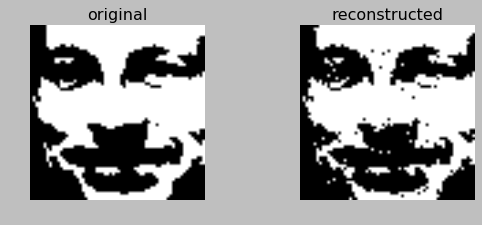

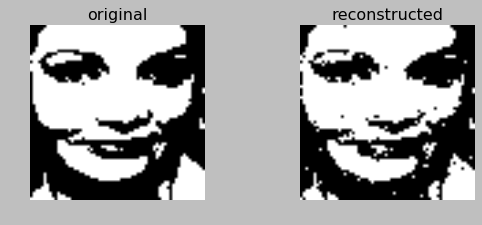

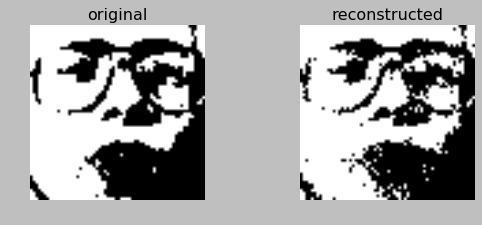

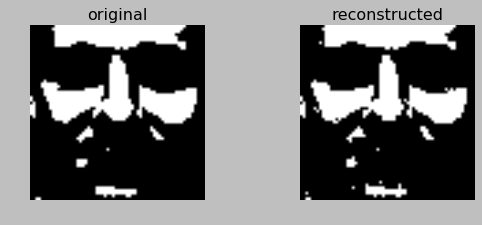

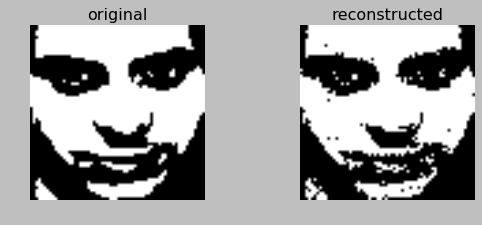

In [16]:
show_reconstruction(X_train, sampled_visible_train)

#### Reconstructed test faces

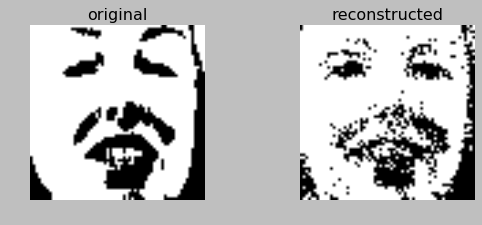

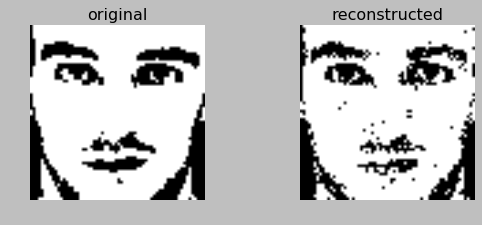

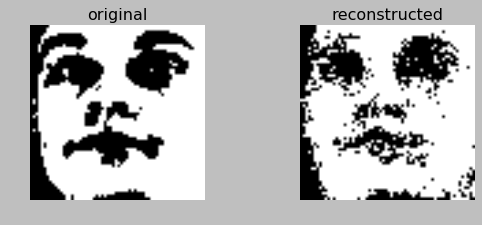

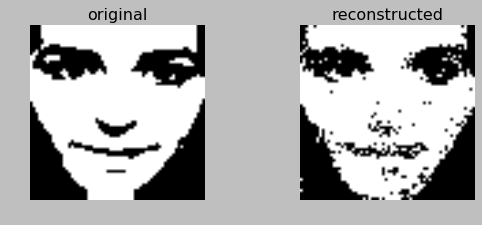

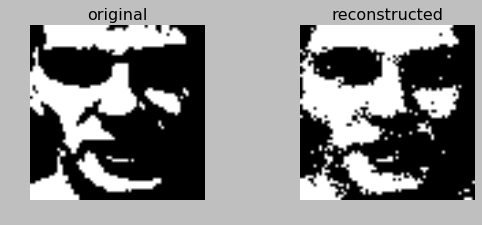

In [17]:
show_reconstruction(X_test, sampled_visible_test)

### Visualizing weights

Let's plot $P(v|h_i)$ for 100 $i$.

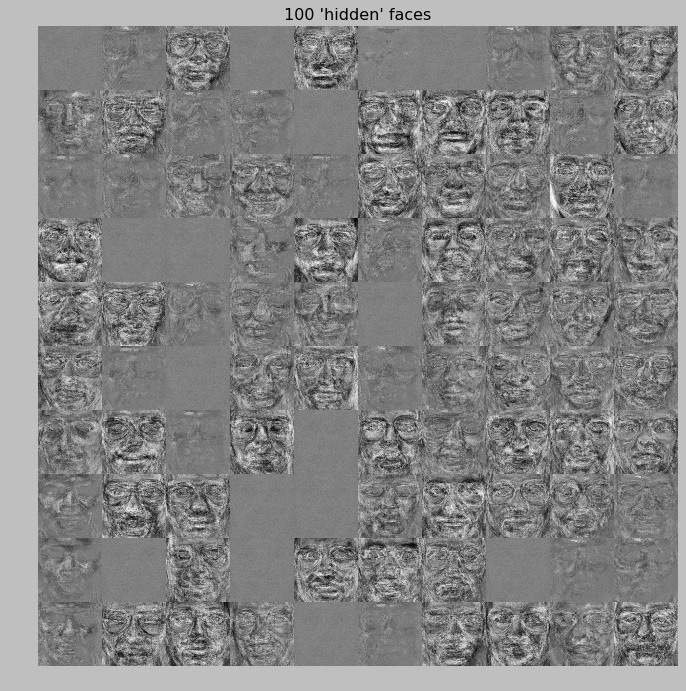

In [25]:
visible_probabilities_from_hidden = probabilities_from_other(
    K.transpose(W_in),
    hidden_input)

hidden_faces = visible_probabilities_from_hidden.eval(
    feed_dict={hidden_input: np.eye(n_hidden)},
    session=K.get_session()
)


side_length = 10
tiled_faces = np.vstack(
  [
      np.hstack(list(hidden_faces[i*side_length:(i+1)*side_length].reshape(-1, 64, 64)))
      for i in range(side_length)
  ]
)

plt.figure(figsize=(16, 10))
plt.title("""{} 'hidden' faces""".format(side_length **2))
plt.imshow(tiled_faces, cmap='gray')
plt.axis('off')
plt.show()